<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/DEEPAR01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""

import logging.config
import os

LOG_CONF = {
    "version": 1,
    "disable_existing_loggers": False,
    "formatters": {
        "simple": {"format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"}
    },
    "handlers": {
        "stream": {
            "class": "logging.StreamHandler",
            "level": "DEBUG",
            "formatter": "simple",
            "stream": "ext://sys.stdout",
        },
    },
    "loggers": {
        "deepar": {"handlers": ["stream"], "level": os.getenv("DF_LOG_LEVEL", "DEBUG"),}
    },
}

logging.config.dictConfig(LOG_CONF)
'''

code_path = './deepar/settings.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [2]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""

'''

code_path = './deepar/__init__.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [3]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""

from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.layers import Layer


class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        """Init."""
        self.output_dim = output_dim
        self.kernel_1, self.kernel_2, self.bias_1, self.bias_2 = [], [], [], []
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """Build the weights and biases."""
        n_weight_rows = input_shape[2]
        self.kernel_1 = self.add_weight(
            name="kernel_1",
            shape=(n_weight_rows, self.output_dim),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.kernel_2 = self.add_weight(
            name="kernel_2",
            shape=(n_weight_rows, self.output_dim),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.bias_1 = self.add_weight(
            name="bias_1",
            shape=(self.output_dim,),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.bias_2 = self.add_weight(
            name="bias_2",
            shape=(self.output_dim,),
            initializer=glorot_normal(),
            trainable=True,
        )
        super(GaussianLayer, self).build(input_shape)

    def call(self, x):
        """Do the layer computation."""
        output_mu = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06
        return [output_mu, output_sig_pos]

    def compute_output_shape(self, input_shape):
        """Calculate the output dimensions.
        The assumption here is that the output ts is always one-dimensional;
        """
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

'''

code_path = './deepar/model/layers.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [4]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""

import math
import tensorflow as tf


def gaussian_likelihood(sigma):
    """Likelihood as per the paper."""

    def gaussian_loss(y_true, y_pred):
        """Updated from paper.
        See DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks.
        """
        return tf.reduce_mean(
            tf.math.log(tf.math.sqrt(2 * math.pi))
            + tf.math.log(sigma)
            + tf.math.truediv(
                tf.math.square(y_true - y_pred), 2 * tf.math.square(sigma)
            )
        )

    return gaussian_loss
'''

code_path = './deepar/model/loss.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [5]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""
import math
from functools import partial
import logging
from typing import Optional, Union

import numpy as np
from numpy.random import normal

from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

from deepar.model.loss import gaussian_likelihood
from deepar.model import NNModel
from deepar.model.layers import GaussianLayer


logger = logging.getLogger(__name__)


class DeepAR(NNModel):
    def __init__(
        self,
        ts_obj,
        steps_per_epoch=50,
        epochs=100,
        loss=gaussian_likelihood,
        optimizer="adam",
        with_custom_nn_structure=None,
    ):
        """Init."""

        self.ts_obj = ts_obj
        self.inputs, self.z_sample = None, None
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.loss = loss
        self.optimizer = optimizer
        self.keras_model = None
        if with_custom_nn_structure:
            self.nn_structure = with_custom_nn_structure
        else:
            self.nn_structure = partial(
                DeepAR.basic_structure,
                n_steps=self.ts_obj.n_steps,
                dimensions=self.ts_obj.dimensions,
            )
        self._output_layer_name = "main_output"
        self.get_intermediate = None

    @staticmethod
    def basic_structure(n_steps=20, dimensions=1):
        """
        This is the method that needs to be patched when changing NN structure
        :return: inputs_shape (tuple), inputs (Tensor), [loc, scale] (a list of theta parameters
        of the target likelihood).
        Please note that I've made up scaling rules of the hidden layer dimensions.
        """
        input_shape = (n_steps, dimensions)
        inputs = Input(shape=input_shape)
        x = LSTM(
            int(4 * (1 + math.pow(math.log(dimensions), 4))),
            return_sequences=True,
            dropout=0.1,
        )(inputs)
        x = Dense(int(4 * (1 + math.log(dimensions))), activation="relu")(x)
        loc, scale = GaussianLayer(dimensions, name="main_output")(x)
        return input_shape, inputs, [loc, scale]

    def fit(
        self,
        epochs: Optional[int] = None,
        verbose: Union[str, int] = "auto",
        patience: int = 10,
    ):
        """Fit model.
        This is called from instantiate and fit().
        Args:
            epochs (Optional[int]): number of epochs to train. If nothing
                defined, take self.epochs. Please the early stopping (patience).
            verbose (Union[str, int]): passed to keras.fit(). Can be
                "auto", 0, or 1.
            patience (int): Number of epochs without without improvement to stop.
        """
        if not epochs:
            epochs = self.epochs
        callback = callbacks.EarlyStopping(monitor="loss", patience=patience)
        self.keras_model.fit(
            ts_generator(self.ts_obj, self.ts_obj.n_steps),
            steps_per_epoch=self.steps_per_epoch,
            epochs=epochs,
            verbose=verbose,
            callbacks=[callback],
        )
        if verbose:
            logger.debug("Model was successfully trained")
        self.get_intermediate = K.function(
            inputs=[self.keras_model.input],
            outputs=self.keras_model.get_layer(self._output_layer_name).output,
        )

    def build_model(self):
        input_shape, inputs, theta = self.nn_structure()
        model = Model(inputs, theta[0])
        model.compile(loss=self.loss(theta[1]), optimizer=self.optimizer)
        self.keras_model = model

    def instantiate_and_fit(
        self,
        epochs: Optional[int] = None,
        verbose: Union[str, int] = "auto",
        do_fit: bool = True,
    ):
        """Compile and train model."""
        self.build_model()
        self.fit(verbose=verbose, epochs=epochs)

    @property
    def model(self):
        return self.keras_model

    def predict_theta_from_input(self, input_list):
        """
        This function takes an input of size equal to the n_steps specified in 'Input' when building the
        network
        :param input_list:
        :return: [[]], a list of list. E.g. when using Gaussian layer this returns a list of two list,
        corresponding to [[mu_values], [sigma_values]]
        """
        if not self.get_intermediate:
            raise ValueError("TF model must be trained first!")

        return self.get_intermediate(input_list)

    def get_sample_prediction(self, sample):
        sample = np.array(sample).reshape(
            (1, self.ts_obj.n_steps, self.ts_obj.dimensions)
        )
        output = self.predict_theta_from_input([sample])
        samples = []
        for mu, sigma in zip(output[0].reshape(-1), output[1].reshape(-1)):
            sample = normal(
                loc=mu, scale=np.sqrt(sigma), size=1
            )  # self.ts_obj.dimensions)
            samples.append(sample)
        return np.array(samples).reshape((self.ts_obj.n_steps, self.ts_obj.dimensions))


def ts_generator(ts_obj, n_steps):
    """
    This is a util generator function for Keras
    :param ts_obj: a Dataset child class object that implements the 'next_batch' method
    :param n_steps: parameter that specifies the length of the net's input tensor
    :return:
    """
    while 1:
        batch = ts_obj.next_batch(1, n_steps)
        yield batch[0], batch[1]
'''

code_path = './deepar/model/lstm.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [6]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""
from abc import ABC


class NNModel(ABC):
    def __init__(self):
        super().__init__()

    def net_structure(self, **kwargs):
        pass

    def instantiate_and_fit(self, **kwargs):
        pass
'''

code_path = './deepar/model/__init__.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [7]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""
from keras import backend as K
import tensorflow as tf
import numpy as np


def set_seed_and_reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def clear_keras_session():
    K.clear_session()
'''

code_path = './deepar/utils/__init__.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [8]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""
from abc import ABC


class Dataset(ABC):
    def __init__(self):
        super().__init__()

    def next_batch(self, **kwargs):
        pass
'''

code_path = './deepar/dataset/__init__.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [9]:
import os

code_content=r'''
# -*- coding: utf-8 -*-
"""
@author: LLY
"""
from deepar.dataset import Dataset
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger("deepar")


class MockTs(Dataset):
    """
    This class generates 'mock' time series data of the form (y = t * np.sin(t/6) / 3 +np.sin(t*2))
    Created mainly for showcase/testing purpose
    """

    def __init__(
        self, dimensions=1, t_min=0, t_max=30, resolution=0.1, batch_size=1, n_steps=10
    ):
        self.dimensions = dimensions
        self.t_min = t_min
        self.t_max = t_max
        self.resolution = resolution
        self.data = True
        self.batch_size = batch_size
        self.n_steps = n_steps

    @staticmethod
    def _time_series(t):
        return t * np.sin(t / 6) / 3 + np.sin(t * 2)

    def next_batch(self, batch_size, n_steps):
        """
        Generate next batch (x, y), generate y by lagging x (1 step)
        """
        Y = []
        for dim in range(self.dimensions):
            t0 = np.random.rand(batch_size, 1) * (
                self.t_max - self.t_min - n_steps * self.resolution
            )
            Ts = t0 + np.arange(0.0, n_steps + 1) * self.resolution
            ys = self._time_series(Ts)
            Y.append(ys[:, :-1].reshape(-1, n_steps, 1))
        return np.concatenate(Y, axis=2), np.concatenate(Y, axis=2)

    def __next__(self):
        """Iterator."""
        return self.next_batch(n_steps=self.n_steps, batch_size=self.batch_size)

    @property
    def mock_ts(self):
        """
        Return the data used for training (ranging from self.t_min and self.t_max, with resolution self.resolution)
        :return: a Numpy array
        """
        t_list = [self.t_min]
        results = [self._time_series(t_list[0])]
        while t_list[-1] < self.t_max:
            t_list.append(t_list[-1] + self.resolution)
            results.append(self._time_series(t_list[-1]))
        return results

    def generate_test_data(self, n_steps):
        """
        Generate test data outside of the training set (t > self.t_max)
        :param n_steps:
        :return:
        """
        t_list = [self.t_max + self.resolution]
        results = [self._time_series(t_list[0])]
        for i in range(1, n_steps):
            t_list.append(t_list[-1] + self.resolution)
            results.append(self._time_series(t_list[-1]))
        return results

    def __iter__(self):
        return self


class TimeSeries(Dataset):
    def __init__(
        self,
        pandas_df,
        one_hot_root_list=None,
        grouping_variable="category",
        scaler=None,
        n_steps=1,
        batch_size=10,
    ):
        super().__init__()
        self.data = pandas_df
        self.one_hot_root_list = one_hot_root_list
        self.grouping_variable = grouping_variable
        if self.data is None:
            raise ValueError("Must provide a Pandas df to instantiate this class")
        self.scaler = scaler
        self.batch_size = batch_size
        self.n_steps = n_steps

    def __next__(self):
        """Iterator."""
        return self.next_batch(n_steps=self.n_steps, batch_size=self.batch_size)

    def _one_hot_padding(self, pandas_df, padding_df):
        """
        Util padding function
        :param padding_df:
        :param one_hot_root_list:
        :return:
        """
        for one_hot_root in self.one_hot_root_list:
            one_hot_columns = [
                i
                for i in pandas_df.columns  # select columns equal to 1
                if i.startswith(one_hot_root) and pandas_df[i].values[0] == 1
            ]
            for col in one_hot_columns:
                padding_df[col] = 1
        return padding_df

    def _pad_ts(self, pandas_df, desired_len, padding_val=0):
        """
        Add padding int to the time series
        :param pandas_df:
        :param desired_len: (int)
        :param padding_val: (int)
        :return: X (feature_space), y
        """
        pad_length = desired_len - pandas_df.shape[0]
        padding_df = pd.concat(
            [
                pd.DataFrame(
                    {col: padding_val for col in pandas_df.columns},
                    index=[i for i in range(pad_length)],
                )
            ]
        )

        if self.one_hot_root_list:
            padding_df = self._one_hot_padding(pandas_df, padding_df)

        return pd.concat([padding_df, pandas_df]).reset_index(drop=True)

    @staticmethod
    def _sample_ts(pandas_df, desired_len):
        """
        :param pandas_df: input pandas df with 'target' columns e features
        :param desired_len: desired sample length (number of rows)
        :param padding_val: default is 0
        :param initial_obs: how many observations to skip at the beginning
        :return: a pandas df (sample)
        """
        if pandas_df.shape[0] < desired_len:
            raise ValueError("Desired sample length is greater than df row len")
        if pandas_df.shape[0] == desired_len:
            return pandas_df

        start_index = np.random.choice(
            [i for i in range(0, pandas_df.shape[0] - desired_len + 1)]
        )
        return pandas_df.iloc[
            start_index : start_index + desired_len,
        ]

    def next_batch(
        self, batch_size, n_steps, target_var="target", verbose=False, padding_value=0
    ):
        """
        :param batch_size: how many time series to be sampled in this batch (int)
        :param n_steps: how many RNN cells (int)
        :param target_var: (str)
        :param verbose: (boolean)
        :param padding_value: (float)
        :return: X (feature space), y
        """

        # Select n_batch time series
        groups_list = self.data[self.grouping_variable].unique()
        np.random.shuffle(groups_list)
        selected_groups = groups_list[:batch_size]
        input_data = self.data[
            self.data[self.grouping_variable].isin(set(selected_groups))
        ]

        # Initial padding for each selected time series to reach n_steps
        sampled = []
        for cat, cat_data in input_data.groupby(self.grouping_variable):
            if cat_data.shape[0] < n_steps:
                sampled_cat_data = self._pad_ts(
                    pandas_df=cat_data, desired_len=n_steps, padding_val=padding_value
                )
            else:
                sampled_cat_data = self._sample_ts(
                    pandas_df=cat_data, desired_len=n_steps
                )
            sampled.append(sampled_cat_data)
            if verbose:
                logger.debug("Sampled data for {}".format(cat))
                logger.debug(sampled_cat_data)
        rnn_output = (
            pd.concat(sampled)
            .drop(columns=self.grouping_variable)
            .reset_index(drop=True)
        )

        if self.scaler:
            batch_scaler = self.scaler()
            n_rows = rnn_output.shape[0]
            # Scaling will have to be extended to handle multiple variables!
            rnn_output["feature_1"] = rnn_output.feature_1.astype("float")
            rnn_output[target_var] = rnn_output[target_var].astype("float")

            rnn_output["feature_1"] = batch_scaler.fit_transform(
                rnn_output.feature_1.values.reshape(n_rows, 1)
            ).reshape(n_rows)
            rnn_output[target_var] = batch_scaler.fit_transform(
                rnn_output[target_var].values.reshape(n_rows, 1)
            ).reshape(n_rows)

        return (
            rnn_output.drop(target_var, 1).values.reshape(batch_size, n_steps, -1),
            rnn_output[target_var].values.reshape(batch_size, n_steps, 1),
        )
'''

code_path = './deepar/dataset/time_series.py'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()

In [10]:
import os

code_content=r'''
numpy
pandas
scipy
tensorflow
seaborn
pytest
keras
'''

code_path = './requirements.txt'
os.makedirs(os.path.dirname(code_path), exist_ok=True)
f = open(code_path, 'w')
f.write(code_content)
f.close()
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
%load_ext autoreload
%autoreload 2

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from deepar.dataset.time_series import MockTs
from deepar.model.lstm import DeepAR

ts = MockTs(dimensions=1)  # you can change this for multivariate time-series!
dp_model = DeepAR(ts, epochs=50)
dp_model.instantiate_and_fit()

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


100%|██████████| 300/300 [00:00<00:00, 521.76it/s]


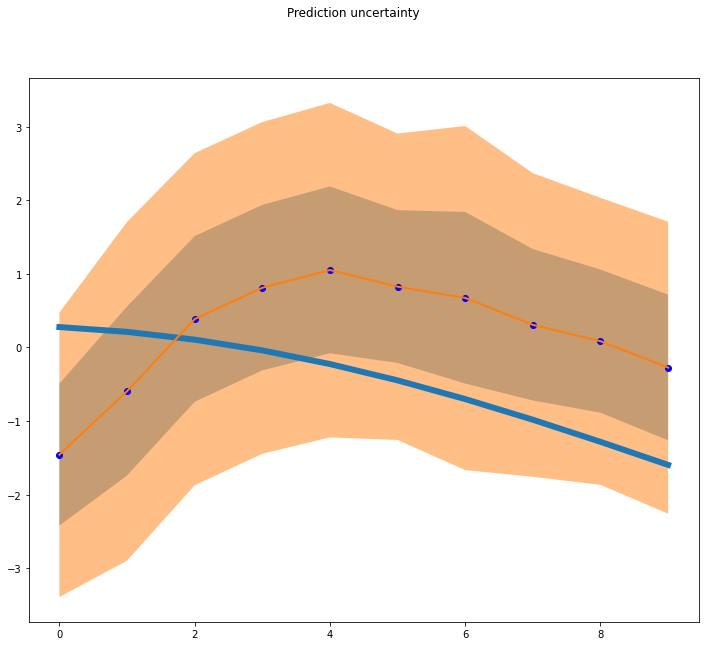

In [12]:
%matplotlib inline
from numpy.random import normal
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

batch = ts.next_batch(1, ts.n_steps)

ress = []
for i in tqdm.tqdm(range(300)):
    ress.append(np.expand_dims(
        dp_model.get_sample_prediction(
            batch[0]
        ), axis=0,
    ))

res_np = np.concatenate(ress, axis=0)
fig = plt.figure(figsize=(12, 10))

for dim in range(ts.dimensions):
    ax = fig.add_subplot(ts.dimensions, 1, dim+1)
    res_df = pd.DataFrame(res_np[:, :, 0]).T
    tot_res = res_df

    ax.plot(batch[1].reshape((ts.n_steps, ts.dimensions))[:, dim], linewidth=6)
    tot_res['mu'] = tot_res.apply(lambda x: np.mean(x), axis=1)
    tot_res['upper'] = tot_res.apply(lambda x: np.mean(x) + np.std(x), axis=1)
    tot_res['lower'] = tot_res.apply(lambda x: np.mean(x) - np.std(x), axis=1)
    tot_res['two_upper'] = tot_res.apply(lambda x: np.mean(x) + 2*np.std(x), axis=1)
    tot_res['two_lower'] = tot_res.apply(lambda x: np.mean(x) - 2*np.std(x), axis=1)

    ax.plot(tot_res.mu, 'bo')
    ax.plot(tot_res.mu, linewidth=2)
    ax.fill_between(x = tot_res.index, y1=tot_res.lower, y2=tot_res.upper, alpha=0.5)
    ax.fill_between(x = tot_res.index, y1=tot_res.two_lower, y2=tot_res.two_upper, alpha=0.5)
    fig.suptitle('Prediction uncertainty')